# Max-Cut 2
Solve the max-cut problem using DWave's qubo generator

Given an undirected graph $G(V,E)$, partition the vertices into 2 subsets such that the number of edges between the 2 subsets is maximized (max edges "cut")

In [1]:
import dimod

import pyqubo
from pyqubo import Spin, Binary, Constraint

from dwave.system.samplers import DWaveSampler
from dwave.system.composites import LazyEmbeddingComposite

import networkx as nx

import numpy as np
import numpy.random as random

import time

## Function for solving QUBO
Given a hamiltonian $H$ in QUBO form, solve for lowest energy solution

In [20]:
def qdict_to_matrix(qubo,qubits):
    Q = np.zeros([len(qubits),len(qubits)])
    for (i,j) in qubo:
        x = int(i[1:])
        y = int(j[1:])
        Q[x,y] = qubo[(i,j)]
    return Q

def solve_qubo(H,
               qubits,
               sampler="CPU", # CPU or QPU
               k=10,
               chain_strength=None):
    """
    Given a hamiltonian, solves the quadratic unconstrained binary
    optimization (QUBO) problem given by
    
        minimize sum(x[i] * Q[i,j] * x[j]
                     for i in range(N),
                     for j in range(i+1, N))
    
    Uses compile() to convert the hamiltonian into matrix (dictionary) form.
    dimod.SimulatedAnnealingSampler is then used, which solves the problem k times through simulated
    annealing (on a regular CPU). This method returns the best solution found.
    """
    assert sampler in ["CPU", "QPU"]
    
    model = H.compile()
    qubo, offset = model.to_qubo()
    bqm = dimod.BinaryQuadraticModel.from_qubo(qubo,offset=offset)
    
    Q = qdict_to_matrix(qubo,qubits)
    n = Q.shape[0]
    nz = len(Q[Q!=0])
    print("Solving QUBO problem (%d vars, %d nz) on %s..." % (n, nz, sampler))
    
    start = time.time()
    
    if sampler == "CPU":
        sampler = dimod.SimulatedAnnealingSampler()
        response = sampler.sample(bqm, num_reads=k)
    else:
        if chain_strength is None:
            chain_strength = int(10 * max(qubo.values()))
        sampler = LazyEmbeddingComposite(DWaveSampler(solver="Advantage_system6.1"))
        response = sampler.sample(bqm, num_reads=k, chain_strength=chain_strength)
        
    elapsed = time.time() - start
    
    print("Solved in %.2f seconds" % elapsed)
    solution = min(response.data(["sample", "energy"]), key=lambda s: s.energy)
    return solution, response, Q

## Generate random graph

73


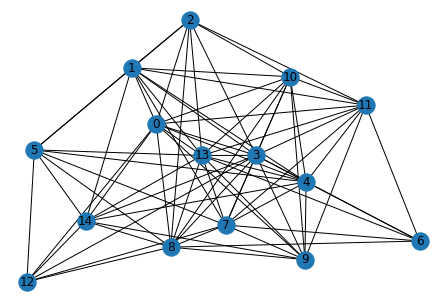

In [68]:
# number of nodes
n = 15
# edge generation probability
p = 0.65
# seed (optional)
seed = 42
#generate graph
graph = nx.gnp_random_graph(n,p,seed)

# draw graph
nx.draw(graph, with_labels=True)

print(len(graph.edges))

## Define hamiltonian
Objective function is: min $y=\sum_{(i,j)\in E}(2x_ix_j-x_i-x_j)$

In [69]:
x = []
for i in graph.nodes:
    x.append(Binary(f'x{i}'))

H = 0
for (i,j) in graph.edges:
    H += 2*x[i]*x[j]-x[i]-x[j]

## Solve on CPU

In [70]:
k=10
# solve problem
solution1, response1, Q = solve_qubo(H,x,"CPU",k)

# display result
print(response1)

Solving QUBO problem (15 vars, 88 nz) on CPU...
Solved in 1.15 seconds
  x0 x1 x10 x11 x12 x13 x14 x2 x3 x4 x5 x6 x7 x8 x9 energy num_oc.
0  1  0   1   0   0   0   1  1  0  0  1  1  1  0  1  -46.0       1
1  0  1   0   1   1   1   0  1  0  1  0  0  0  1  1  -46.0       1
2  1  0   1   0   0   0   1  0  1  0  1  1  1  0  0  -46.0       1
3  0  1   0   1   1   1   0  0  1  1  0  0  0  1  0  -46.0       1
4  1  0   1   0   0   0   1  1  0  0  1  1  1  0  1  -46.0       1
5  1  0   1   0   0   0   1  1  0  0  1  1  1  0  1  -46.0       1
6  0  1   0   1   1   1   0  1  0  1  0  0  0  1  1  -46.0       1
7  0  1   0   0   1   1   0  1  0  1  0  0  0  1  1  -46.0       1
9  0  1   0   0   1   1   0  1  0  1  0  1  0  1  1  -46.0       1
8  0  1   1   0   1   0   1  1  0  1  0  1  0  0  1  -45.0       1
['BINARY', 10 rows, 10 samples, 15 variables]


In [71]:
print(solution1)

Sample(sample={'x0': 1, 'x1': 0, 'x10': 1, 'x11': 0, 'x12': 0, 'x13': 0, 'x14': 1, 'x2': 1, 'x3': 0, 'x4': 0, 'x5': 1, 'x6': 1, 'x7': 1, 'x8': 0, 'x9': 1}, energy=-46.0)


In [72]:
print(solution1.sample)

{'x0': 1, 'x1': 0, 'x10': 1, 'x11': 0, 'x12': 0, 'x13': 0, 'x14': 1, 'x2': 1, 'x3': 0, 'x4': 0, 'x5': 1, 'x6': 1, 'x7': 1, 'x8': 0, 'x9': 1}


## Redraw graph to show solution

edges cut:  46.0


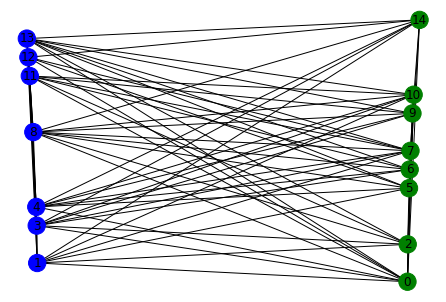

In [73]:
# assign colors
color_map = []
for node in graph:
    if solution1.sample[f'x{node}'] < 0.5:
        color_map.append('blue')
    else: 
        color_map.append('green')
        
# assign positions     
pos = {}
for i in range(n):
    if solution1.sample[f'x{i}'] > 0.5:
        pos[i] = (2*n+0.005*i**2,i)
    else:
        pos[i] = (0-0.005*i**2,i)
nx.draw(graph,pos=pos, node_color=color_map, with_labels=True)

print("edges cut: ", -solution1.energy)

## Solve on QPU

In [77]:
k=2000
# solve problem
solution, response, Q = solve_qubo(H,x,"QPU",k)

# display result
print(response)

Solving QUBO problem (15 vars, 88 nz) on QPU...
Solved in 2.26 seconds
     x0 x1 x10 x11 x12 x13 x14 x2 x3 x4 x5 x6 x7 x8 x9 energy num_oc. ...
0     0  1   0   1   1   1   0  0  0  1  0  0  0  1  1  -46.0       1 ...
1     0  1   0   0   1   1   0  1  0  1  0  1  0  1  1  -46.0       1 ...
2     1  0   1   0   0   0   1  1  1  0  1  1  1  0  0  -46.0       1 ...
3     0  1   0   0   1   1   0  1  0  1  0  1  0  0  1  -45.0       1 ...
4     1  0   0   0   0   0   1  1  1  0  1  1  1  0  1  -45.0       1 ...
5     0  1   0   0   1   1   0  0  1  1  0  0  0  1  1  -45.0       1 ...
6     0  1   1   0   1   0   1  1  0  1  0  1  0  0  1  -45.0       1 ...
7     1  1   1   0   1   0   0  0  1  0  1  1  0  0  1  -45.0       1 ...
8     1  1   1   0   0   0   0  0  1  0  1  1  0  0  1  -45.0       1 ...
9     1  0   1   1   0   0   1  0  1  0  1  1  0  0  0  -45.0       1 ...
10    1  0   0   1   0   0   1  1  0  1  0  0  1  1  0  -45.0       1 ...
11    1  0   1   1   0   0   1  0  1  0  

In [78]:
print(solution)

Sample(sample={'x0': 0, 'x1': 1, 'x10': 0, 'x11': 1, 'x12': 1, 'x13': 1, 'x14': 0, 'x2': 0, 'x3': 0, 'x4': 1, 'x5': 0, 'x6': 0, 'x7': 0, 'x8': 1, 'x9': 1}, energy=-46.0)


edges cut:  46.0


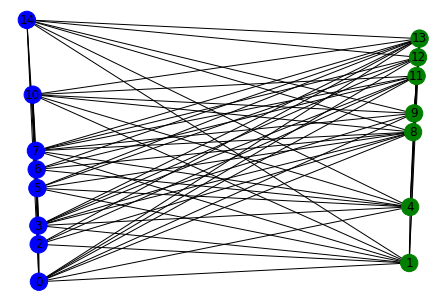

In [79]:
# assign colors
color_map = []
for node in graph:
    if solution.sample[f'x{node}'] < 0.5:
        color_map.append('blue')
    else: 
        color_map.append('green')
        
# assign positions     
pos = {}
for i in range(n):
    if solution.sample[f'x{i}'] > 0.5:
        pos[i] = (2*n+0.005*i**2,i)
    else:
        pos[i] = (0-0.005*i**2,i)
nx.draw(graph,pos=pos, node_color=color_map, with_labels=True)

print("edges cut: ", -solution.energy)